In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import distance, procrustes
from sklearn.manifold import MDS
from skbio.stats.ordination import pcoa
from qiime2 import Artifact

%matplotlib inline

# Prep data

In [2]:
tax = Artifact.load("Data/tax-6-table.qza").view(pd.DataFrame)

#Convert to relative abundance
tax_mat = np.matrix(tax)
tax_mat /= np.sum(tax_mat, axis=1)

tax = pd.DataFrame(tax_mat,
                   index=tax.index,
                   columns=tax.columns)

In [3]:
metabo = pd.read_csv("Data/IBS-ID-list.txt", sep="\t", encoding='unicode_escape')

#Clean up rows and columns
metabo = metabo[metabo["Sample"].isna()==False]
metabo.loc[metabo["Subject ID.1"].isna(), "Subject ID.1"] = metabo.loc[metabo["Subject ID.1"].isna(), "Sample"]
metabo.set_index("Subject ID.1", inplace=True)
metabo.drop(["Sample", "Subject ID","Unnamed: 3"], axis=1, inplace=True)

#Clean up column names
metabo.columns = list(metabo.columns[:2]) + [" ".join(col.split(" ")[:-4]) for col in list(metabo.columns[2:])]

#Impute NQ as LLOQ/2
metabo.replace(to_replace="NQ",
               value=np.nan,
               inplace=True)

metabo.loc["LLOQ", "Sample Weight"] = 0
metabo.loc["LLOQ",:] = metabo.loc["LLOQ",:].astype(float)
metabo.loc["half LLOQ",:] = metabo.loc["LLOQ"]/2
metabo.iloc[2:-1,:] = metabo.iloc[2:-1,:].fillna(metabo.loc["half LLOQ",:])

#Drop ULOQ/LLOQ
metabo.drop(["half LLOQ","LLOQ","ULOQ", "Preservative", "BLOQ Values", "ALOQ Values"], inplace=True)

#We can drop these too - quantities are already microg/g sample weight
metabo.drop(["Sample Weight", "Date and Time"], axis=1, inplace=True)

In [4]:
#indexes are the same
print(len(set(metabo.index)&set(tax.index))==len(tax.index))

#reindex according to tax
metabo = metabo.reindex(tax.index)

True


In [17]:
metabo = metabo.astype(float)

# Ordination

### Trying standard MDS

In [18]:
tax_braycurt = distance.squareform(distance.pdist(tax,metric="braycurtis"))

metabo_braycurt = distance.squareform(distance.pdist(metabo,metric="braycurtis"))

In [19]:
mdsa = MDS(dissimilarity="precomputed", random_state=42)
mdsb = MDS(dissimilarity="precomputed", random_state=42)

tax_mds = mdsa.fit_transform(tax_braycurt)

metabo_mds = mdsb.fit_transform(metabo_braycurt)

In [20]:
tax_stress = np.sqrt(mdsa.stress_ / (0.5 * np.sum(tax_braycurt**2)))
metabo_stress = np.sqrt(mdsb.stress_ / (0.5 * np.sum(metabo_braycurt**2)))


print(f"Kruskal's stress for taxonomy bray curtis ordination: {tax_stress} \n")
print(f"Kruskal's stress for metabolomics ordination: {metabo_stress} \n")

Kruskal's stress for taxonomy bray curtis ordination: 0.25982100677011843 

Kruskal's stress for metabolomics ordination: 0.15981379821439193 



#### Oof that's high stress, let's try filtering out some features

In [21]:
filt_tax = tax.loc[:,(tax.sum()>0.005)]

In [22]:
filt_tax_braycurt = distance.squareform(distance.pdist(filt_tax,metric="braycurtis"))

mdsc = MDS(dissimilarity="precomputed", random_state=42)
filt_tax_mds = mdsc.fit_transform(filt_tax_braycurt)

filt_tax_stress = np.sqrt(mdsc.stress_ / (0.5 * np.sum(filt_tax_braycurt**2)))

print(f"Kruskal's stress for filtered taxonomy bray curtis ordination: {filt_tax_stress} \n")

Kruskal's stress for filtered taxonomy bray curtis ordination: 0.25907330951595753 



#### Practically no improvement - let's try PCoA

In [23]:
tax_pcoa_coords = pd.DataFrame(pcoa(tax_braycurt).samples)[["PC1","PC2","PC3"]]
tax_pcoa_coords.index = tax.index

metabo_pcoa_coords = pd.DataFrame(pcoa(metabo_braycurt).samples)[["PC1","PC2","PC3"]]
metabo_pcoa_coords.index = metabo.index

/Users/johnsterrett/mambaforge/envs/qiime2-2022.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.048161664330468916 and the largest is 1.6483610812998675.
  warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the 

In [24]:
tax_pcoa_coords.head()

,PC1,PC2,PC3
HBC 104,0.255368,-0.017313,-0.112267
HBC 106,-0.099560,-0.091837,-0.014662
HBC 108,-0.056991,-0.028317,-0.011353
HBC 109,-0.044018,0.046269,-0.075198
HBC 111,-0.070533,-0.076369,-0.048671


In [25]:
print(f"Tax: \n{pcoa(tax_braycurt).proportion_explained[:3]}\n")

print(f"Metabolome: \n{pcoa(metabo_braycurt).proportion_explained[:3]}")

Tax: 
PC1    0.294377
PC2    0.148592
PC3    0.077050
dtype: float64

Metabolome: 
PC1    0.529038
PC2    0.166813
PC3    0.093752
dtype: float64


/Users/johnsterrett/mambaforge/envs/qiime2-2022.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.048161664330468916 and the largest is 1.6483610812998675.
  warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the 

#### Okay I'd say that's an acceptable proportion explained

## Procrustes

In [26]:
mtx1, mtx2, disparity = procrustes(metabo_pcoa_coords,
                                   tax_pcoa_coords)
print(f'disparity: {disparity}')

disparity: 0.8528737451812005


In [27]:
mtx1.shape

(45, 3)

In [28]:
proplot = pd.concat([pd.DataFrame(mtx1),
                     pd.DataFrame(mtx2)])
proplot.columns = ["PC1","PC2","PC3"]
proplot["Dataset"] = ["Microbiome"]*mtx1.shape[0] + ["Lipidome"]*mtx2.shape[0]

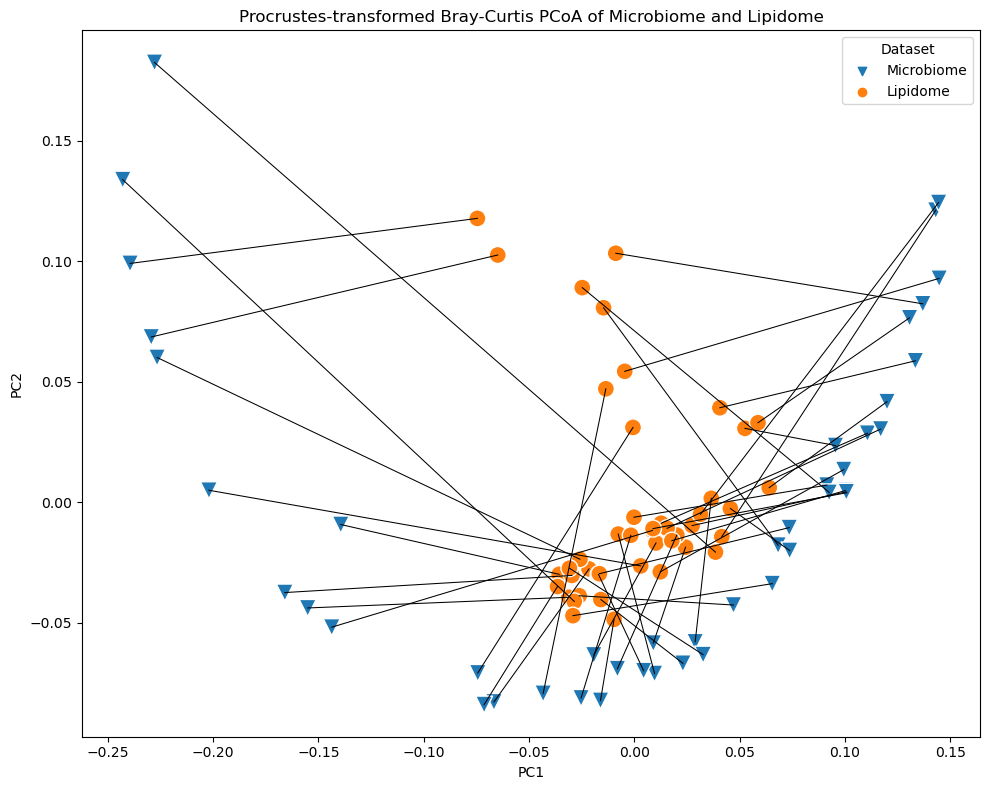

In [30]:
ax = sns.scatterplot(x="PC1",y="PC2",
                     style="Dataset",hue="Dataset",
                     data=proplot,
                     markers=["v","o"],
                     s=150)

for i in range(len(mtx1)):
    plt.plot([mtx1[i,0],mtx2[i,0]],
             [mtx1[i,1],mtx2[i,1]],
             c="black", linewidth=0.75)
    
plt.gcf().set_size_inches(10,8)
ax.set_title("Procrustes-transformed Bray-Curtis PCoA of Microbiome and Lipidome", fontsize="large")

plt.tight_layout()
plt.savefig("Figures/Procrustes-PCoA.pdf")
plt.show()

## PROTEST
### Randomly sample both

In [195]:
rows, cols = metabo.shape
n=10000

disparities = []
for x in range(n):
    metabo_rand = metabo_pcoa_coords.sample(frac=1,axis=0).reset_index(drop=True)
    tax_rand = tax_pcoa_coords.sample(frac=1,axis=0).reset_index(drop=True)
    
    mtx1_rand, mtx2_rand, disparity_rand = procrustes(metabo_rand,
                                                      tax_rand)
    disparities.append(disparity_rand)

pval = (sum([disparity > d for d in disparities])+1)/(n+1)

print(f'Procrustean randomization test pval: {pval}')

Procrustean randomization test pval: 0.0020997900209979003


Text(0, 0.5, 'Occurrences during 10,000 permutations')

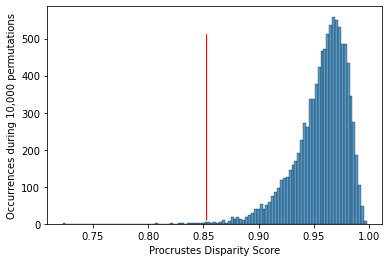

In [204]:
ax = sns.histplot(disparities)
ax.arrow(disparity,10,
         0,500,
         width=0.0001,
         color="red") 
ax.set_xlabel("Procrustes Disparity Score")
ax.set_ylabel("Occurrences during 10,000 permutations")

### Randomly sample one (standard version)

In [197]:
rows, cols = metabo.shape
n=10000

disparities = []
for x in range(n):
    metabo_rand = metabo_pcoa_coords.sample(frac=1,axis=0).reset_index(drop=True)
    
    mtx1_rand, mtx2_rand, disparity_rand = procrustes(metabo_rand, tax_rand)
    disparities.append(disparity_rand)

pval = (sum([disparity > d for d in disparities])+1)/(n+1)

print(f'Procrustean randomization test pval: {pval}')

Procrustean randomization test pval: 0.0023997600239976003


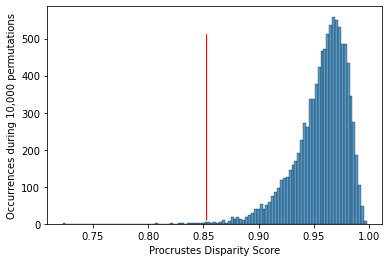

In [206]:
ax = sns.histplot(disparities)
ax.arrow(disparity,10,
         0,500,
         width=0.0001,
         color="red") 
ax.set_xlabel("Procrustes Disparity Score")
ax.set_ylabel("Occurrences during 10,000 permutations")

plt.savefig("Figures/PROTEST-hist.pdf")
plt.show()